<a href="https://www.kaggle.com/code/jonghyuk/company-bankruptcy-prediction-transcription?scriptVersionId=137223097" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# 1. Load Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/company-bankruptcy-prediction/data.csv


In [2]:
df=pd.read_csv("/kaggle/input/company-bankruptcy-prediction/data.csv")

# 2. Import Modules

In [3]:
# 기본적인 파이썬 모듈 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import ipywidgets as widgets
from ipywidgets import interact

# RandomForest Classifier를 활용한 Feature Selection
from sklearn.feature_selection import SelectFromModel

# 데이터가 imbalanced한 경우 사용되는 over/under sampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# 결측값을 메꿔주는 impute ~ imputer
# from eli5.sklearn import PermutationImportance
from sklearn.impute import SimpleImputer


# 평가지표를 위한 confusion matrix
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

# 모델 불러오기
# from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier


# 그리드서치와 파이프라인(보팅)
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline

import warnings
import gc
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 3. EDA & Preprocessing

In [4]:
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [5]:
pd.set_option('display.max_rows', 50)
df.isnull().sum()

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

In [6]:
df.describe()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,...,6819.000000,6.819000e+03,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.000000,6819.0,6819.000000
mean,0.032263,0.505180,0.558625,0.553589,0.607948,0.607929,0.998755,0.797190,0.809084,0.303623,...,0.807760,1.862942e+07,0.623915,0.607946,0.840402,0.280365,0.027541,0.565358,1.0,0.047578
std,0.176710,0.060686,0.065620,0.061595,0.016934,0.016916,0.013010,0.012869,0.013601,0.011163,...,0.040332,3.764501e+08,0.012290,0.016934,0.014523,0.014463,0.015668,0.013214,0.0,0.050014
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,0.000000,0.476527,0.535543,0.527277,0.600445,0.600434,0.998969,0.797386,0.809312,0.303466,...,0.796750,9.036205e-04,0.623636,0.600443,0.840115,0.276944,0.026791,0.565158,1.0,0.024477
50%,0.000000,0.502706,0.559802,0.552278,0.605997,0.605976,0.999022,0.797464,0.809375,0.303525,...,0.810619,2.085213e-03,0.623879,0.605998,0.841179,0.278778,0.026808,0.565252,1.0,0.033798
75%,0.000000,0.535563,0.589157,0.584105,0.613914,0.613842,0.999095,0.797579,0.809469,0.303585,...,0.826455,5.269777e-03,0.624168,0.613913,0.842357,0.281449,0.026913,0.565725,1.0,0.052838
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,9.820000e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [8]:
# rename column "Bankrupt?" to "is_Bankrupt"
df.rename(columns={'Bankrupt?': "is_Bankrupt"}, inplace=True)
df.head()

,is_Bankrupt,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490


In [9]:
X = df.iloc[:,1:]
X

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,0.781241,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,0.781550,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,0.781588,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,0.781586,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,0.781546,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,0.781663,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


In [10]:
# Target data
y = df.iloc[:,:1]
y

,is_Bankrupt
0,1
1,1
2,1
3,1
4,1
...,...
6814,0
6815,0
6816,0
6817,0


In [11]:
y.value_counts()

is_Bankrupt
0              6599
1               220
dtype: int64

In [12]:
y.value_counts(normalize=True)

is_Bankrupt
0              0.967737
1              0.032263
dtype: float64

## SMOTE : OverSampling  

Imbalanced data를 분석할 때,  
minority class의 개수를 majority class의 개수만큼 늘려서 진행한다.

In [13]:
# 낮은 비율 클래스(minority class)를 높은 비율 클래스 데이터 갯수로 맞춰주는 OverSampling
smote = SMOTE(sampling_strategy=0.251,random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 16)

In [14]:
print(X_resampled.shape, y_resampled.shape)

(8255, 95) (8255, 1)


In [15]:
y_resampled.value_counts(normalize=True)

is_Bankrupt
0              0.799394
1              0.200606
dtype: float64

In [16]:
y_resampled.value_counts()

is_Bankrupt
0              6599
1              1656
dtype: int64

In [17]:
feats = [col for col in df.columns if col != 'is_Bankrupt']
len(feats)

95

In [18]:
''' 
# Need to Fix

def rmse_expm1(pred, true):
    return -np.sqrt(np.mean((np.expm1(pred) - np.expm1(true)) **2 ))

# 모델 평가
def evaluate(X_data, y_data, model):    
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
    model.fit(X_train, y_train, verbose=False)
    pred = model.predcit(X_test)
    score = rmse_expm1(pred, y_test)
    return score 
'''

' \n# Need to Fix\n\ndef rmse_expm1(pred, true):\n    return -np.sqrt(np.mean((np.expm1(pred) - np.expm1(true)) **2 ))\n\n# 모델 평가\ndef evaluate(X_data, y_data, model):    \n    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)\n    model.fit(X_train, y_train, verbose=False)\n    pred = model.predcit(X_test)\n    score = rmse_expm1(pred, y_test)\n    return score \n'

In [19]:
'''
# Basic line
lgb = LGBMRegressor(objective='regression', n_estimators=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)
lgb.fit(X_train, y_train, verbose=100)
pred = lgb.predict(X_test)
score = rmse_expm1(pred, y_test)
score
'''

"\n# Basic line\nlgb = LGBMRegressor(objective='regression', n_estimators=100)\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 16)\nlgb.fit(X_train, y_train, verbose=100)\npred = lgb.predict(X_test)\nscore = rmse_expm1(pred, y_test)\nscore\n"

# 4. Modeling

## 1. RandomForest

In [20]:
# Basic line
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [21]:
import math
print(math.sqrt(mse(rf_pred, y_test)))

0.16324985402594153


## 2. LogisticRegression

In [22]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
lr_pred = lr.predict(X_test)

In [23]:
lr_pred

array([0, 0, 0, ..., 0, 0, 0])

In [24]:
lr.predict_proba(X_test)

array([[0.7470945 , 0.2529055 ],
       [0.84975589, 0.15024411],
       [0.63408285, 0.36591715],
       ...,
       [0.88490581, 0.11509419],
       [0.69484939, 0.30515061],
       [0.93213284, 0.06786716]])

In [25]:
print(math.sqrt(mse(lr_pred, y_test)))

0.4443603123815928


## 3. Light GBM

In [26]:
lgb = LGBMClassifier(n_estimators=1000,num_leaves=64,n_jobs=-1,boost_from_average=False)
lgb.fit(X_train,y_train)
lgb_pred = lgb.predict(X_test)

In [27]:
print(math.sqrt(mse(lgb_pred, y_test)))

0.11802944945573945


### 4. K-Nearest Neighbor(KNN)

In [28]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

In [29]:
print(math.sqrt(mse(knn_pred, y_test)))

0.2795254263233233


### 5. Decision Tree

In [30]:
dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf = 3)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)

In [31]:
print(math.sqrt(mse(dt_pred, y_test)))

0.2373383603094518


### Features Selection

In [32]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [33]:
sel.get_support()

array([ True, False,  True, False, False, False,  True,  True,  True,
        True, False, False, False,  True, False, False, False, False,
        True, False, False, False,  True, False, False, False, False,
       False, False,  True, False, False, False,  True, False,  True,
        True,  True, False,  True, False, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False,  True,  True, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False,  True, False, False, False,  True,
        True, False, False, False,  True])

In [34]:
selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

24

# 5. Evaluation

In [35]:
def metrics(y_test, pred):
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test,pred)
    roc_score = roc_auc_score(y_test,pred, average='macro')
    print('정확도 : {0:.2f}, 정밀도 : {1:.2f}, 재현율 : {2:.2f}'.format(accuracy,precision,recall))
    print('f1-score : {0:.2f}, auc : {1:.2f}'.format(f1,roc_score,recall))

In [36]:
print('-- Random Forest Classifier --')
metrics(y_test, rf_pred)
print('----- Decision Tree -----')
metrics(y_test, dt_pred)
print('-------- KNN --------')
metrics(y_test, knn_pred)
print('-- Logistic Regression --')
metrics(y_test, lr_pred)
print('----- Light GBM -----')
metrics(y_test, lgb_pred)

-- Random Forest Classifier --
정확도 : 0.97, 정밀도 : 0.94, 재현율 : 0.91
f1-score : 0.93, auc : 0.95
----- Decision Tree -----
정확도 : 0.94, 정밀도 : 0.87, 재현율 : 0.82
f1-score : 0.85, auc : 0.90
-------- KNN --------
정확도 : 0.92, 정밀도 : 0.76, 재현율 : 0.85
f1-score : 0.80, auc : 0.89
-- Logistic Regression --
정확도 : 0.80, 정밀도 : 0.34, 재현율 : 0.05
f1-score : 0.09, auc : 0.52
----- Light GBM -----
정확도 : 0.99, 정밀도 : 0.96, 재현율 : 0.97
f1-score : 0.96, auc : 0.98


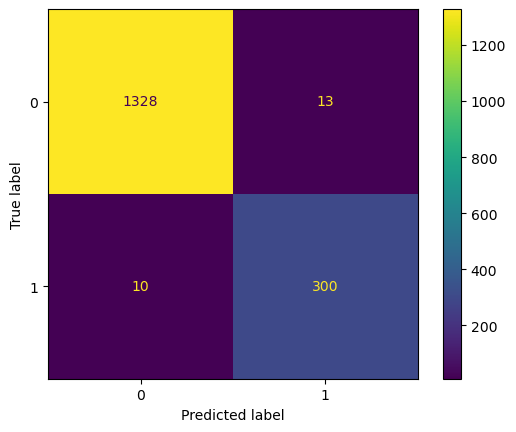

In [37]:
# Light GBM의 Confusion Matrix
# confusion_matrix(y_test, lgb_pred)
ConfusionMatrixDisplay.from_estimator(lgb, X_test, y_test)

### Feature Extracion_test

In [38]:
## 2. model.feature_importances_ w/ (RF & LGBM)
lgbm = LGBMClassifier(n_estimators=100,)
lgbm.fit(X_train, y_train)

# Get feature_importance scores
feature_importance = lgbm.feature_importances_

# Get the indices of the most important features
sorted_indices = np.argsort(feature_importance)[::-1]

# Get the names of the most important features
selected_features = X.columns[sorted_indices[:15]] # 

In [39]:
feature_importance

array([ 26,   8,  21,  19,   6,  12,  11,  14,  60,  67,  38, 109,  21,
        93,  24,  21,   9,   2,  31,  19,  46,   9,   6,  27,  46,  18,
         6,  19,  57,  38,  22,  19,  11,  63,  49,  85,   1,   5,  34,
        64,  58,   5,   3,  10,  25,  17,  72,  71,  84,  20,  83,  36,
        96,   3,  28,  22,  28,   7,  42,  27,   7,  55,  53,  41,  18,
        19,  36,  61,  10,  46,  63,  64,   8, 114,  43,  39,   0,   0,
        24,  19,  23,  23,  19,  14,   0,  26,  35,  30,   3,  25,   1,
        43,  42,   0,  23], dtype=int32)

In [40]:
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_indices

array([73, 11, 52, 13, 35, 48, 50, 46, 47,  9, 39, 71, 70, 33, 67,  8, 40,
       28, 61, 62, 34, 69, 20, 24, 74, 91, 58, 92, 63, 75, 10, 29, 51, 66,
       86, 38, 18, 87, 56, 54, 59, 23,  0, 85, 89, 44, 78, 14, 94, 80, 81,
       30, 55, 15, 12,  2, 49, 19, 65, 82,  3, 27, 79, 31, 25, 64, 45, 83,
        7,  5,  6, 32, 68, 43, 21, 16, 72,  1, 57, 60, 22, 26,  4, 37, 41,
       42, 88, 53, 17, 90, 36, 84, 77, 93, 76])

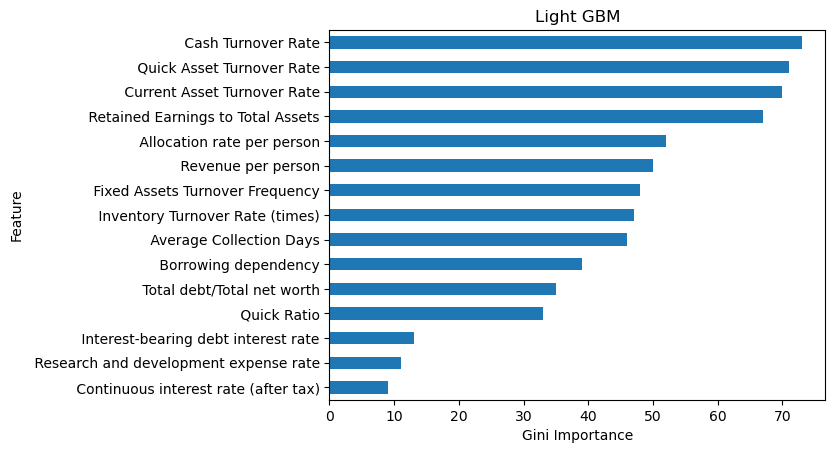

In [41]:
# Put importances into a Series
feat_imp = pd.Series(sorted_indices[:15],index=selected_features).sort_values()

# Plot series
feat_imp.head(15).plot(kind='barh')
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Light GBM");

In [42]:
## 2. model.feature_importances_ w/ (RF & LGBM)
# Get feature_importance scores
rf_feature_importance = rf.feature_importances_

# Get the indices of the most important features
rf_sorted_indices = np.argsort(rf_feature_importance)[::-1]

# Get the names of the most important features
rf_selected_features = X.columns[rf_sorted_indices[:15]] # 

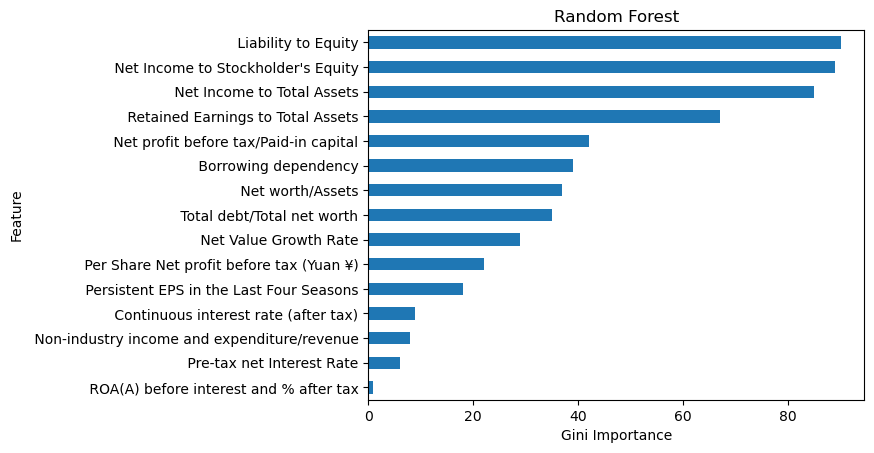

In [43]:
# Put importances into a Series
rf_feat_imp = pd.Series(rf_sorted_indices[:15],index=rf_selected_features).sort_values()

# Plot series
rf_feat_imp.head(15).plot(kind='barh')
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Random Forest");

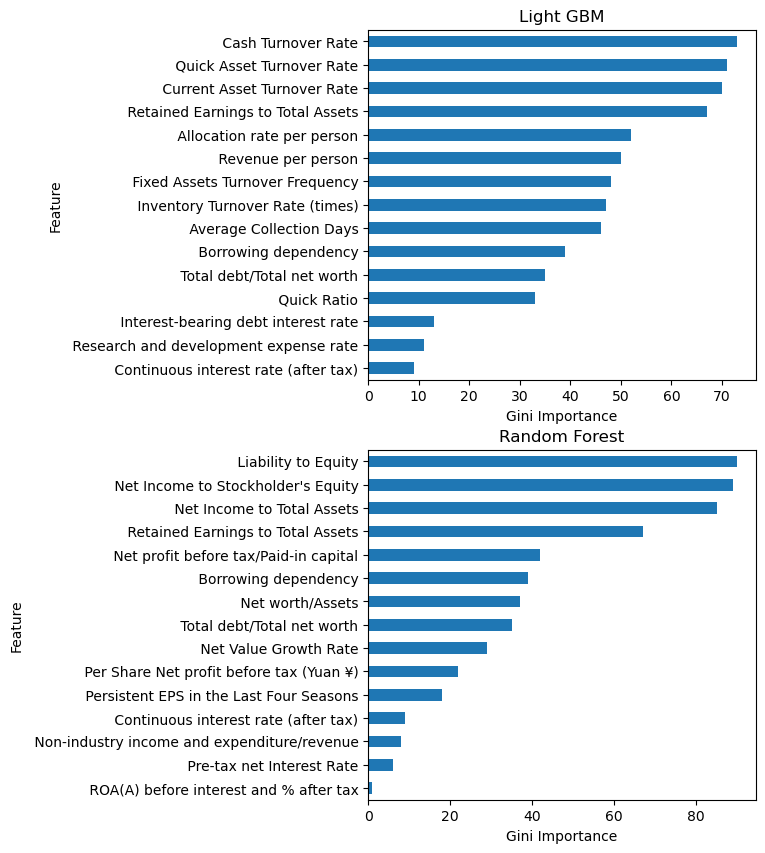

In [44]:
fig = plt.figure(figsize=(5, 10),)
plt.subplot(2, 1, 1)
feat_imp.head(15).plot(kind='barh')
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Light GBM");

plt.subplot(2, 1, 2)
rf_feat_imp.head(15).plot(kind='barh')
plt.xlabel("Gini Importance")
plt.ylabel("Feature")
plt.title("Random Forest");

In [45]:
for f in rf_feat_imp:
    if f in feat_imp:
        print(f)

'''
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)
shap_feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)
shap.summary_plot(shap_values, X_train)
'''

'\nexplainer = shap.TreeExplainer(model)\nshap_values = explainer.shap_values(X_train)\nshap_feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)\nshap.summary_plot(shap_values, X_train)\n'

In [46]:
'''
%%time
shap_archive = rfe(X_train, y_train, 'shap')
'''

"\n%%time\nshap_archive = rfe(X_train, y_train, 'shap')\n"

In [47]:
'''
# Hyper parameter setting

params = {'colsample_bytree': [0.8, 0.9],
              'learning_rate': [0.2, 0.22],
              'max_depth': [15, 20],
              'min_child_weight' : [4, 6],
              'n_estimators': [1000],
              'subsample': [0.5, 0.6,],
              'num_leaves' : [50, 80],
              'min_data_in_leaf': [10, 20],
              }


lgb_grid = GridSearchCV(lgb,
                        parameters,
                        scoring = 'r2',
                        cv = 3,
                        n_jobs = -1,
                        verbose=True)

lgb_grid.fit(X_train, Y_train)
'''

"\n# Hyper parameter setting\n\nparams = {'colsample_bytree': [0.8, 0.9],\n              'learning_rate': [0.2, 0.22],\n              'max_depth': [15, 20],\n              'min_child_weight' : [4, 6],\n              'n_estimators': [1000],\n              'subsample': [0.5, 0.6,],\n              'num_leaves' : [50, 80],\n              'min_data_in_leaf': [10, 20],\n              }\n\n\nlgb_grid = GridSearchCV(lgb,\n                        parameters,\n                        scoring = 'r2',\n                        cv = 3,\n                        n_jobs = -1,\n                        verbose=True)\n\nlgb_grid.fit(X_train, Y_train)\n"

In [48]:
%%capture
print('hello')

#### 1. RFE

In [49]:
# %%time
# basic_archive = rfe(X, Y, 'basic')

#### 2. One-shot

In [50]:
'''
feat_importance = pd.Series(lgb.feature_importances_, index=feats).sort_values(ascending=False)
for i in range(40, 90, 5):
    print(i, evaluate(df[feat_imp.iloc[:1].index], df['is_Bankrupt']))
'''

"\nfeat_importance = pd.Series(lgb.feature_importances_, index=feats).sort_values(ascending=False)\nfor i in range(40, 90, 5):\n    print(i, evaluate(df[feat_imp.iloc[:1].index], df['is_Bankrupt']))\n"

In [51]:
def rfe(X_data, y_data, method, ratio=0.9, min_feats=40):
    feats = X_data.columns.tolist()
    archive = pd.DataFrame(columns=['model', 'n_feats', 'feats', 'score'])
    
    while True:
        model = LGBMRegressor(objective='regression', num_iterations=10**5)
        X_train, X_test, y_train, y_test = train_test_split(x_data[feats], y_data, random_state=0)
        model.fit(X_train, y_train)
        pred = model.predict(X_test)
        score = rmse_expm1(pred, y_test)
        
        n_feats = len(feats)
        print(n_feats, score)
        
        archive = archive.append({'model': model, 'n_feats': n_feats, 'feats': feats, 'score': score}, ignore_index=True)
        if method == 'basic':
            feat_imp = pd.Series(model.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'perm':
            perm = PermutationImportance(model, random_state=0).fit(x_val, y_val)
            feat_imp = pd.Series(perm.feature_importances_, index=feats).sort_values(ascending=False)
        elif method == 'shap':
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(x_data[feats])
            feat_imp = pd.Series(np.abs(shap_values).mean(axis=0), index=feats).sort_values(ascending=False)
            
        next_n_feats = int(n_feats * ratio)
        if next_n_feats < min_feats:
            break
        else:
            feats = feat_imp.iloc[:next_n_feats].index.tolist()
    return archive

In [52]:
# ## 1. RFE (Recursive Features Elimination)
# from sklearn.feature_selection import RFE
# rfe = RFE(estimator=rf, n_features_to_select=5) 
# rfe.fit(X_train, y_train)

# [rfe.support_]
